In [3]:
import torch
import os
from chemflow.utils import index_to_token


root_path = "/cluster/project/krause/frankem/chemflow/outputs/2026-01-30/10-45-28"
path = os.path.join(root_path, "results.pt")
atom_token_path = (
    "/cluster/project/krause/frankem/chemflow/data/qm9/processed/atom_tokens.txt"
)
results = torch.load(path, weights_only=False)
atom_tokens = open(atom_token_path).read().splitlines()

atom_mask_index = atom_tokens.index("<MASK>")

edge_token_path = (
    "/cluster/project/krause/frankem/chemflow/data/qm9/processed/edge_tokens.txt"
)
edge_tokens = open(edge_token_path).read().splitlines()

charge_token_path = (
    "/cluster/project/krause/frankem/chemflow/data/qm9/processed/charge_tokens.txt"
)
charge_tokens = open(charge_token_path).read().splitlines()

edge_mask_index = edge_tokens.index("<MASK>")
edge_no_bond_index = edge_tokens.index("<NO_BOND>")

edge_tokens.remove("<MASK>")
atom_tokens.remove("<MASK>")

distribution_path = (
    "/cluster/project/krause/frankem/chemflow/data/qm9/processed/distributions.pt"
)
distributions = torch.load(distribution_path)
coordinate_std = distributions["coordinate_std"]

RuntimeError: PytorchStreamReader failed reading zip archive: invalid header or archive is corrupted

In [30]:
from chemflow.utils import EdgeAligner

edge_aligner = EdgeAligner()


def process_traj(mol_list):
    new_trajs = []

    for mol in mol_list:
        x = mol.x
        a = mol.a.tolist()
        a = [index_to_token(atom_tokens, i) for i in a]

        a = [atom if atom != "<DEATH>" else "He" for atom in a]

        c = mol.c.tolist()
        c = [index_to_token(charge_tokens, i) for i in c]

        edge_infos = edge_aligner.align_edges(
            source_group=(mol.edge_index, [mol.e]),
        )
        edge_index_triu, e_pred_triu = (
            edge_infos["edge_index"],
            edge_infos["edge_attr"][0],
        )

        edge_index = edge_index_triu.T.tolist()
        e = e_pred_triu.tolist()
        e = [index_to_token(edge_tokens, i) for i in e]

        e_sanitized = []
        edge_index_sanitized = []
        # remove edges with <NO_BOND> or <MASK>
        for i, edge in enumerate(e):
            if edge == "<NO_BOND>" or edge == "<MASK>":
                continue
            e_sanitized.append(int(edge))
            edge_index_sanitized.append(edge_index[i])

        new_trajs.append(
            {
                "atoms": a,
                "pos": x,
                "edges": edge_index_sanitized,
                "edge_types": e_sanitized,
                "charges": c,
            }
        )
    return new_trajs


trajs = [process_traj(i) for i in results[0]]

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

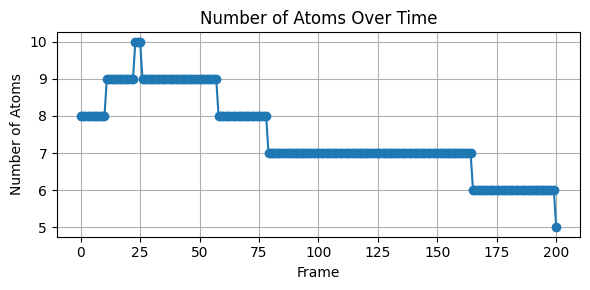

In [38]:
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
from rdkit.Chem.rdDetermineBonds import DetermineBonds
import matplotlib.pyplot as plt


def visualize_variable_topology(trajectory_frames, width=800, height=400):
    """
    Visualizes a trajectory where atom counts and types change.

    Args:
        trajectory_frames (list): A list of dicts. Each dict must have:
            - 'atoms': List of symbols (e.g., ['C', 'H'])
            - 'pos': List of [x, y, z] coordinates
            - 'edges': List of (start_idx, end_idx) tuples
            - 'edge_types': List of bond orders (1, 2, 1.5, etc.)
    """

    # Map your edge types to RDKit BondTypes
    # Adjust keys (1, 2, etc.) to match your specific data format
    bond_mapping = {
        1: Chem.BondType.SINGLE,
        1.0: Chem.BondType.SINGLE,
        2: Chem.BondType.DOUBLE,
        2.0: Chem.BondType.DOUBLE,
        3: Chem.BondType.TRIPLE,
        1.5: Chem.BondType.AROMATIC,
    }

    combined_sdf_string = ""

    # 1. Iterate over every frame to build distinct molecules
    for frame in trajectory_frames:
        mol = Chem.RWMol()

        # A. Add Atoms
        for i, symbol in enumerate(frame["atoms"]):
            atom = Chem.Atom(symbol)
            atom.SetFormalCharge(int(frame["charges"][i]))
            mol.AddAtom(atom)

        # B. Add Bonds
        # We loop through edges and edge_types simultaneously
        for (src, dst), b_type in zip(frame["edges"], frame["edge_types"]):
            rdkit_type = bond_mapping.get(b_type, Chem.BondType.SINGLE)
            mol.AddBond(int(src), int(dst), rdkit_type)

        # C. Set Positions (Conformer)
        conf = Chem.Conformer(len(frame["atoms"]))
        for i, (x, y, z) in enumerate(frame["pos"]):
            conf.SetAtomPosition(i, (float(x), float(y), float(z)))

        mol.AddConformer(conf)

        # D. Convert to SDF Block and append to master string
        # '$$$$' is the delimiter between molecules in an SDF file
        mol_block = Chem.MolToMolBlock(mol)
        combined_sdf_string += mol_block + "$$$$\n"

    # 2. Visualize with py3Dmol
    view = py3Dmol.view(width=width, height=height)

    # Load the multi-molecule string
    view.addModelsAsFrames(combined_sdf_string, "sdf")

    # 3. Styling
    view.setStyle({"stick": {"radius": 0.15}, "sphere": {"scale": 0.2}})

    # 4. Animation Settings
    # 'interval' controls speed (ms per frame)
    view.animate({"loop": "forward", "interval": 50})
    view.zoomTo()

    return view


traj_idx = 5
# Run the visualization
view = visualize_variable_topology(trajs[traj_idx])
view.show()

# --- Plotting the number of atoms over time ---
num_atoms_per_frame = [len(frame["atoms"]) for frame in trajs[traj_idx]]
plt.figure(figsize=(6, 3))
plt.plot(np.arange(len(num_atoms_per_frame)), num_atoms_per_frame, marker="o")
plt.title("Number of Atoms Over Time")
plt.xlabel("Frame")
plt.ylabel("Number of Atoms")
plt.grid(True)
plt.tight_layout()
plt.show()